In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [51]:
## Setup
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [52]:
def sample_z(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [53]:
latent_dim = 2
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = layers.Lambda(sample_z)([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_6[0][0]                   
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 3136)         0           conv2d_7[0][0]                   
____________________________________________________________________________________________

In [54]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [55]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

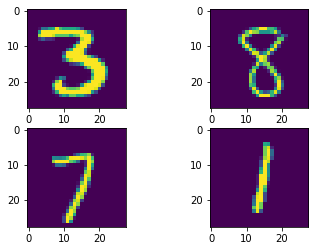

In [56]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

plt.figure(1)
plt.subplot(221)
plt.imshow(mnist_digits[12][:,:,0])

plt.subplot(222)
plt.imshow(mnist_digits[144][:,:,0])

plt.subplot(223)
plt.imshow(mnist_digits[2666][:,:,0])

plt.subplot(224)
plt.imshow(mnist_digits[39888][:,:,0])
plt.show()

In [57]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 4s 7ms/step - loss: 207.3724 - reconstruction_loss: 205.2293 - kl_loss: 2.1431
Epoch 2/30
547/547 [==============================] - 4s 7ms/step - loss: 184.1933 - reconstruction_loss: 181.7391 - kl_loss: 2.4542
Epoch 3/30
547/547 [==============================] - 4s 7ms/step - loss: 166.4575 - reconstruction_loss: 162.6039 - kl_loss: 3.8537
Epoch 4/30
547/547 [==============================] - 4s 7ms/step - loss: 161.1563 - reconstruction_loss: 157.1913 - kl_loss: 3.9651
Epoch 5/30
547/547 [==============================] - 4s 7ms/step - loss: 158.1563 - reconstruction_loss: 154.1365 - kl_loss: 4.0197
Epoch 6/30
547/547 [==============================] - 4s 7ms/step - loss: 156.2655 - reconstruction_loss: 152.2232 - kl_loss: 4.0423
Epoch 7/30
547/547 [==============================] - 4s 7ms/step - loss: 154.7405 - reconstruction_loss: 150.7202 - kl_loss: 4.0203
Epoch 8/30
547/547 [==============================] - 4s 7ms/step - l

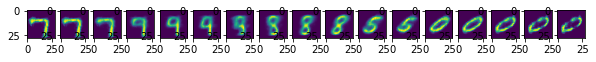

In [95]:
# Visualize images
#Single decoded image with random input latent vector (of size 1x2)
#Latent space range is about -5 to 5 so pick random values within this range
#Try starting with -1, 1 and slowly go up to -1.5,1.5 and see how it morphs from 
#one image to the other.
plt.figure(figsize=(10, 8))
c = 1
r = [-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
for i in r:
    plt.subplot(1, len(r), c)
    sample_vector = np.array([[i,-0.6]]) #mu_1, mu_2
    decoded_example = decoder.predict(sample_vector)
    decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
    plt.imshow(decoded_example_reshaped)
    c = c + 1
plt.show()

In [58]:
"""
## Display a grid of sampled digits
"""
import matplotlib.pyplot as plt
def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

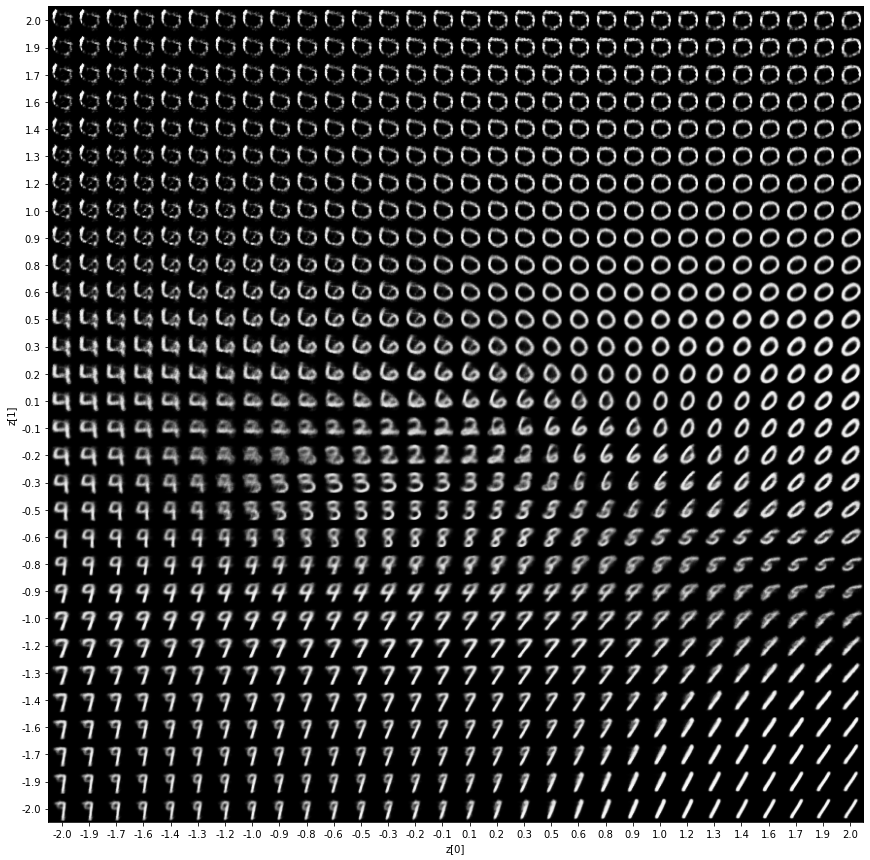

In [59]:
plot_latent(encoder, decoder)

In [60]:
"""
## Display how the latent space clusters different digit classes
"""
def plot_label_clusters(encoder, decoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

In [20]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

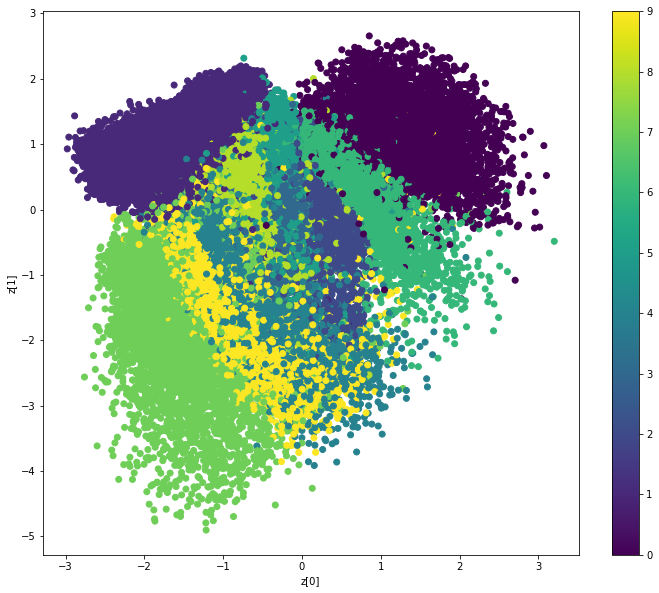

In [21]:
plot_label_clusters(encoder, decoder, x_train, y_train)

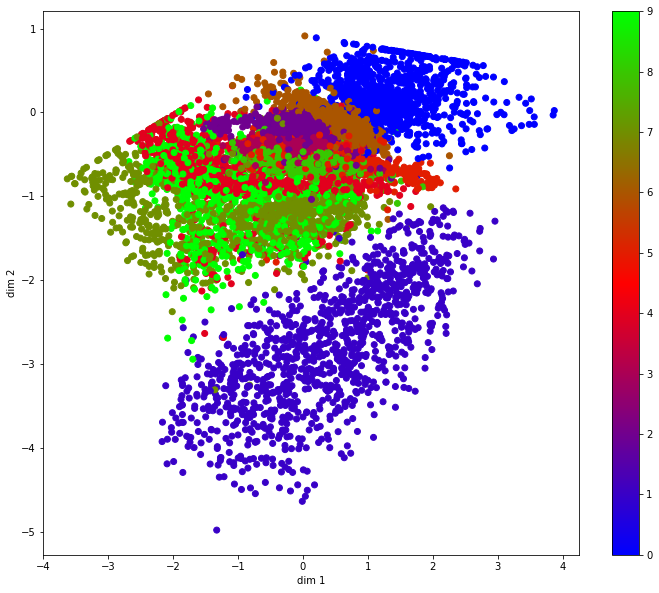

In [96]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_test = np.expand_dims(x_test, -1).astype("float32") / 255
mu, sig, _ = encoder.predict(x_test)
#Plot dim1 and dim2 for mu
plt.figure(figsize=(12, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

In [97]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
pred = encoder.predict(x_train)

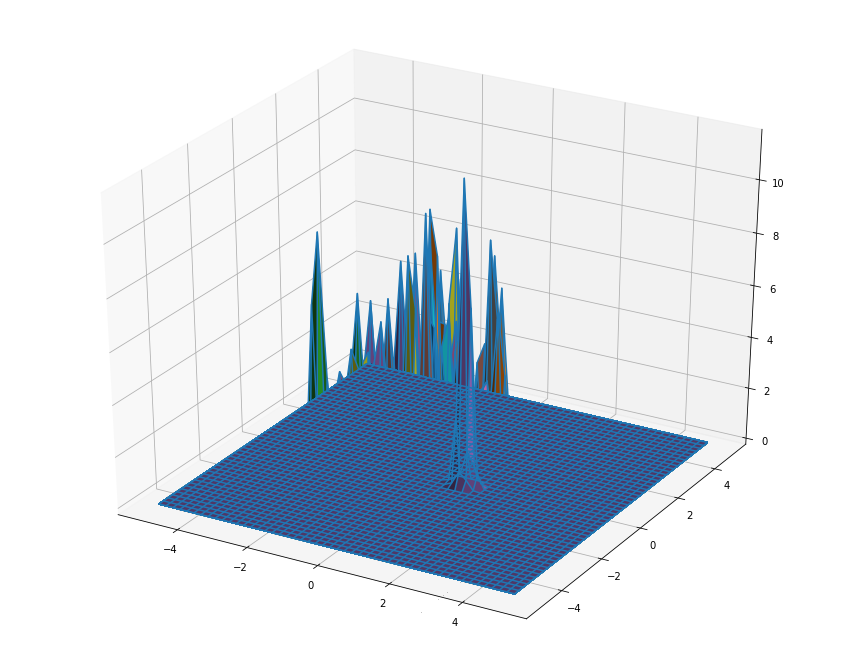

In [98]:
import numpy as np
from scipy.stats import multivariate_normal

x, y = np.mgrid[-5.0:5.0:50j, -5.0:5.0:50j]

# Need an (N, 2) array of (x, y) pairs.
xy = np.column_stack([x.flat, y.flat])

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

for i in range(60):
    mu = np.array(pred[0][i])
    sigma = np.array(pred[1][i])
    covariance = np.diag(np.sqrt(np.exp(sigma)))
    z = multivariate_normal.pdf(xy, mean=mu, cov=covariance)
    z = z.reshape(x.shape)
    ax.plot_surface(x,y,z)
    ax.plot_wireframe(x,y,z)
plt.show()

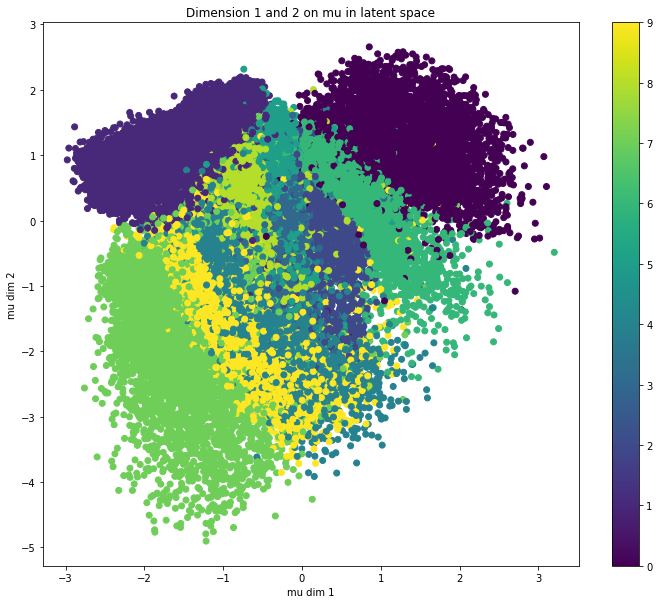

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
n_components = 3
fig = plt.figure(figsize=(12, 10))
plt.scatter(mu_1, mu_2, c = y_train)
plt.title(f"Dimension 1 and 2 on mu in latent space")
plt.colorbar()
plt.xlabel("mu dim 1")
plt.ylabel("mu dim 2");